<a href="https://colab.research.google.com/github/prudhvi193/Analyzing-K-Means-Clustering-Algorithms-using-PySpark-/blob/main/K-Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***K-Means Clustering***

In [ ]:
# Name : Prudhviraj Sheela | OSU CWID : A20228857
# Name : Aman Masipeddi | OSU CWID : A20198116  

!pip install pyspark

     |████████████████████████████████| 204.2MB 70kB/s 
     |████████████████████████████████| 204kB 37.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=726d3b50f1115efe3041309515c63fb4255902d79609154d0f335d39f8617333
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
import pyspark # Importing PySpark
from pyspark import SparkContext 
import numpy as np
import itertools
from operator import add
import random
k = 10 # Number of clusters
I = 20 # Number of Iterations
data_file = '/content/data.txt'
data_content  = np.genfromtxt(data_file) # We initially use genfrmtxt for loading data and get the data into an array
entries,dimensions = data_content.shape # This stores the details about the number of entries and its associated dimensions

In [ ]:
sc = SparkContext("local","K-Means Algorithm: Clustering algorithm with random centroid initialization") # Creating the Spark Context
rdd1 = sc.textFile(data_file) # We read the text file and then preprocess it accordingly
rdd2 = rdd1.map(lambda x : x.split()) # We split the data to collect individual data point as a list
rdd3 = rdd2.map(lambda x : [float(i) for i in x]) # Converting each data point in the list from string to float
rdd4 = rdd3.zipWithIndex().map(lambda x : (x[1],x[0])) # Assiging each data point an index

***Initial Random K-Centroids Computation***

In [ ]:
# In this step for k-Means we generate the k random centroids as required

# The below function generates the random centroids and assigns each obtained centroids with an index associated
def random_generated_centroids(original_data,clusters_number):
  cluster_data = sc.parallelize(original_data.takeSample(False, clusters_number))
  centroids_data = cluster_data.map(lambda x : x[1]) # Accessing the data point from the cluster obtained
  centroids_data = centroids_data.zipWithIndex().map(lambda x : (x[1],x[0])) # Assiging each centroid an index
  return centroids_data
  
generated_centroids = random_generated_centroids(rdd4,k) # This stores the generated centroids

In [ ]:
# Below are the initial random clusters obtained for K-Means
print("\033[1m" + "K-Centroids obtained in K-Means.ipynb" + "\033[1m")
print("\n")
for item in generated_centroids.collect():
  print(item)

K-Centroids obtained in K-Means.ipynb


(0, [0.32, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.29, 0.48, 0.0, 0.0, 0.16, 0.0, 0.0, 2.43, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.0, 0.0, 1.704, 47.0, 167.0, 0.0])
(1, [0.0, 0.36, 0.36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.47, 0.0, 0.36, 8.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.121, 0.0, 0.0, 0.063, 0.0, 0.507, 7.326, 43.0, 359.0, 0.0])
(2, [0.28, 0.0, 0.28, 0.0, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.87, 0.0, 0.86, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.154, 0.0, 0.308, 0.0, 0.0, 1.148, 4.0, 54.0, 0.0])
(3, [0.26, 0.0, 0.26, 0.0

***Eucledian Distance Computation***

In [ ]:
# The below function generates the eucledian distance associated between the data point and the centroid
def euclidean_distance_calculation(centroid_data, original_data):
  centroid_number = np.array(centroid_data[1]) # In this we collect the cluster's centroid data point
  datapoint_details = np.array(original_data[1]) # In this we store each data point
  euclidean_distance = np.sqrt(np.sum((centroid_number - datapoint_details)**2)) # Eucledian distance computed is stored in this variable
  return (original_data[0], (centroid_data[0],euclidean_distance)) # Return the (original data point, (associated cluster's centroid, eucledian distance obtained in between the points))

# The below function caluclates the minimum distance obtained for each cluster and assigns those data points to that associated cluster
def minimum_distance(data_row):
  data_index = data_row[0] # Obtaining index of the cluster's centroid
  distance_centroids = data_row[1] # Getting the list of eucledian distances computed
  centroid_minimum_index = -1 # Initialize the centroid's mimimum index to '-1' initially
  min_distance = -1 # Initialize the minimum distance to '-1' initially
  centroid_closest = None # Initialize the closest centroid value to 'None' initially
  for i in distance_centroids: # In the below iterations we try to obtain the minimum distance for each data point i,e; the centroids
    index_centroid = i[0]
    distance_euclidean = i[1]
    if (distance_euclidean < min_distance) or (min_distance == -1): # In this we check the if the obtained eucledian distance is minimum or not and attach that data point to the centroid closest
      min_distance = distance_euclidean
      centroid_minimum_index = index_centroid
      centroid_closest = (centroid_minimum_index, min_distance)
  return (data_index, centroid_closest) # Returning the data points that are closest to the choosen centroid

# In this function we assign the data points to each associated cluster for which we pass inputs as original data and random obtained centroids
def cluster_assignment(centroids_data, original_data):
  centroid = centroids_data.cartesian(original_data) # Obtaining all the combinations possible with the initial centroids obtained and the original data
  distance_centroids_original_data = centroid.map(lambda a : euclidean_distance_calculation(a[0],a[1])) # Calculating eucledian distance for each combination obtained
  assign_datato_cluster_closest = distance_centroids_original_data.groupByKey().map(lambda a : (a[0],list(a[1]))).map(lambda a : minimum_distance(a)) # Evaluating for the minimum distance that is obtained for computing the cost function
  return assign_datato_cluster_closest # Returning the data points closest to the cluster centroids associated

# In the below functions we compute for the next set of centroids for the next iteration
def computing_centroid(indexof_centroid, elementsof_cluster):
  final_cluster_elements = []
  for item in elementsof_cluster:
    final_cluster_elements.append(item[0])
  array_average = list(np.average(final_cluster_elements, axis = 0)) # Centroid coordinates computation
  centroid_obtained = (indexof_centroid, array_average)
  return centroid_obtained

# Computing new centroids from the previous centroids obtained in the before iterations
def computing_centroids(min_distance):
  cluster_data = min_distance.join(rdd4).map(lambda a : (a[1][0][0],(a[1][1],a[1][0][1])))
  cluster_data = cluster_data.groupByKey().map(lambda a : (a[0],list(a[1])))
  centroids_obtained = cluster_data.map(lambda a : computing_centroid(a[0],a[1]))
  return centroids_obtained

In [ ]:
iter = 0 # This variable is to update the number of iterations
final_res = np.zeros((I,2)) # This variable stores the final eucledian cost obtained for each iteration
gen_centroids = generated_centroids # These are initial centroids obtained in the above step
cost_eucledian = dict() # This variable stores the eucledian cost of each iteration obtaine for computing the percentages of cost function associated for eucledian metric

# In the below step we iterate the algorithm through I=20 iterations for evaluating the distance metrics and their associated cost functions
while iter < I:

  iter += 1 # Incrementing each iteration

  assign_datato_cluster = cluster_assignment(gen_centroids, rdd4) # Obtaining the details of data points assigned for all the clusters associated

  centroids_new_computed = computing_centroids(assign_datato_cluster) # Computing for the next set of cluster's centroids for the next set of iterations

  clusters_assigned = assign_datato_cluster.map(lambda a : a[1][1]**2) # Collecting all the centroids assigned for each cluster

  costfun_eucledian = clusters_assigned.sum() # We find the cost function for each iteration by summing all the centroid points for the associated clusters

  print("Iteration Number %.1d : %.2f" %(iter,costfun_eucledian)) # We print the output of costfun obtained at each iteration

  cost_eucledian[iter] = costfun_eucledian # Stores the eucledian distance obtained for each iteration for computing its percentage and measure performances

  final_res[iter-1,:] = np.array([iter, costfun_eucledian]) # In this we store the iteration and its corresponding cost function obtaine for plotting the graph in successive steps

  gen_centroids = sc.parallelize(centroids_new_computed.collect()) # This stores the next set of centroids for the next iterations and again the process continues accordingly

Iteration Number 1 : 955844429.75
Iteration Number 2 : 770606550.11
Iteration Number 3 : 713994150.32
Iteration Number 4 : 669544358.32
Iteration Number 5 : 593738239.31
Iteration Number 6 : 554699520.20
Iteration Number 7 : 537124280.85
Iteration Number 8 : 522491566.84
Iteration Number 9 : 509276106.89
Iteration Number 10 : 497843149.66
Iteration Number 11 : 489690778.70
Iteration Number 12 : 483876251.23
Iteration Number 13 : 479260562.35
Iteration Number 14 : 475621541.59
Iteration Number 15 : 472029945.98
Iteration Number 16 : 469600133.00
Iteration Number 17 : 467874696.81
Iteration Number 18 : 466653537.67
Iteration Number 19 : 465425481.59
Iteration Number 20 : 464584435.44


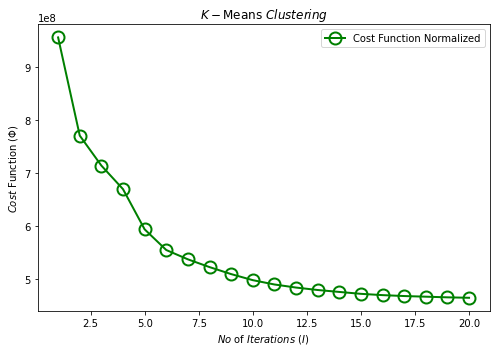

In [ ]:
# Below packages are necessary for creating the line plots
import matplotlib as mplib
import matplotlib.pyplot as pl
figure1, axes1 = pl.subplots(1,1,figsize=(7,5)) # Specifying the dimensions of graph
# In the below step we assign a line plot for the iterations and the cost function
axes1.plot(final_res[:,0], final_res[:,1], 'go-', linewidth = 2, markersize = 12, markeredgewidth = 2, label = 'Cost Function Normalized', fillstyle = 'none')
axes1.set_xlabel("$No$ of $Iterations$ $(I)$") # Setting the x-label to no.of iterations
axes1.set_ylabel("$Cost$ Function $(Φ)$") # Setting the y-label to cost function of eucledian
axes1.set_title("$K-$Means $Clustering$") # Assigning the title for the graph
axes1.legend(loc=0)
figure1.tight_layout() # Adjusts the graph to a tight layout
pl.show() # Displays the plot

***Manhattan Distance Computation***

In [ ]:
# The below function generates the manhattan distance associated between the data point and the centroid
def manhattan_distance_calculation(centroid_data, original_data):
  centroid_number = np.array(centroid_data[1]) # In this we collect the cluster's centroid data point
  datapoint_details = np.array(original_data[1]) # In this we store each data point
  manhattan_distance = np.sqrt(np.sum(np.abs(centroid_number - datapoint_details))) # Manhattan distance computed is stored in this variable
  return (original_data[0], (centroid_data[0],manhattan_distance)) # Return the (original data point, (associated cluster's centroid, manhattan distance obtained in between the points))

# The below function caluclates the minimum distance obtained for each cluster and assigns those data points to that associated cluster
def minimum1_distance(data_row):
  data_index = data_row[0] # Obtaining index of the cluster's centroid
  distance_centroids = data_row[1] # Getting the list of eucledian distances computed
  centroid_minimum_index = -1 # Initialize the centroid's mimimum index to '-1' initially
  min_distance = -1 # Initialize the minimum distance to '-1' initially
  centroid_closest = None # Initialize the closest centroid value to 'None' initially
  for i in distance_centroids: # In the below iterations we try to obtain the minimum distance for each data point i,e; the centroids
    index_centroid = i[0]
    distance_manhattan = i[1]
    if (distance_manhattan < min_distance) or (min_distance == -1): # In this we check the if the obtained eucledian distance is minimum or not and attach that data point to the centroid closest
      min_distance = distance_manhattan
      centroid_minimum_index = index_centroid
      centroid_closest = (centroid_minimum_index, min_distance)
  return (data_index, centroid_closest) # Returning the data points that are closest to the choosen centroid

# In this function we assign the data points to each associated cluster for which we pass inputs as original data and random obtained centroids
def cluster1_assignment(centroids_data, original_data):
  centroid = centroids_data.cartesian(original_data) # Obtaining all the combinations possible with the initial centroids obtained and the original data
  distance_centroids_original_data = centroid.map(lambda a : manhattan_distance_calculation(a[0],a[1]))  # Calculating manhattan distance for each combination obtained
  assign_datato_cluster_closest = distance_centroids_original_data.groupByKey().map(lambda a : (a[0],list(a[1]))).map(lambda a : minimum1_distance(a)) # Evaluating for the minimum distance that is obtained for computing the cost function
  return assign_datato_cluster_closest # Returning the data points closest to the cluster centroids associated

# In the below function we compute for the next set of centroids for the next iteration
def computing1_centroid(indexof_centroid, elementsof_cluster):
  final_cluster_elements = []
  for item in elementsof_cluster:
    final_cluster_elements.append(item[0])
  array_average = list(np.average(final_cluster_elements, axis = 0)) # Centroid coordinates computation
  centroid_obtained = (indexof_centroid, array_average)
  return centroid_obtained

# Computing new centroids from the previous centroids obtained in the before iterations
def computing1_centroids(min_distance):
  cluster_data = min_distance.join(rdd4).map(lambda a : (a[1][0][0],(a[1][1],a[1][0][1])))
  cluster_data = cluster_data.groupByKey().map(lambda a : (a[0],list(a[1])))
  centroids_obtained = cluster_data.map(lambda a : computing1_centroid(a[0],a[1]))
  return centroids_obtained

In [ ]:
iter1 = 0 # This variable is to update the number of iterations
final_res1 = np.zeros((I,2)) # This variable stores the final manhattan cost obtained for each iteration
gen_centroids1 = generated_centroids # These are initial centroids obtained in the above step
cost_manhattan = dict() # This variable stores the eucledian cost of each iteration obtaine for computing the percentages of cost function associated for manhattan metric

# In the below step we iterate the algorithm through I=20 iterations for evaluating the distance metrics and their associated cost functions
while iter1 < I:

  iter1 += 1 # Incrementing each iteration

  assign_datato_cluster1 = cluster1_assignment(gen_centroids1, rdd4) # Obtaining the details of data points assigned for all the clusters associated

  centroids_new_computed1 = computing1_centroids(assign_datato_cluster1) # Computing for the next set of cluster's centroids for the next set of iterations

  clusters_assigned1 = assign_datato_cluster1.map(lambda a : a[1][1]**2) # Collecting all the centroids assigned for each cluster and finding their manhattan cost function distance

  costfun_manhattan = clusters_assigned1.sum() # We find the cost function for each iteration by summing all the centroid points for the associated clusters

  print("Iteration Number %.1d : %.2f" %(iter1,costfun_manhattan)) # We print the output of costfun obtained at each iteration

  cost_manhattan[iter1] = costfun_manhattan # Stores the manhattan distance obtained for each iteration for computing its percentage and measure performances

  final_res1[iter1-1,:] = np.array([iter1, costfun_manhattan]) # In this we store the iteration and its corresponding cost function obtaine for plotting the graph in successive steps

  gen_centroids1 = sc.parallelize(centroids_new_computed1.collect()) # This stores the next set of centroids for the next iterations and again the process continues accordingly

Iteration Number 1 : 726705.14
Iteration Number 2 : 636808.85
Iteration Number 3 : 615798.24
Iteration Number 4 : 596109.33
Iteration Number 5 : 565889.28
Iteration Number 6 : 553109.94
Iteration Number 7 : 547507.88
Iteration Number 8 : 542410.26
Iteration Number 9 : 541645.45
Iteration Number 10 : 539732.05
Iteration Number 11 : 537037.04
Iteration Number 12 : 529036.52
Iteration Number 13 : 522884.05
Iteration Number 14 : 514936.73
Iteration Number 15 : 510307.67
Iteration Number 16 : 509884.18
Iteration Number 17 : 508656.54
Iteration Number 18 : 507280.86
Iteration Number 19 : 507084.12
Iteration Number 20 : 507304.03


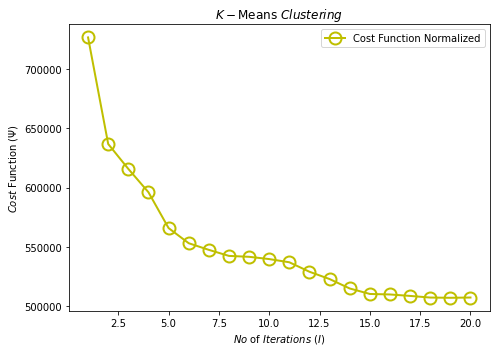

In [ ]:
figure2, axes2 = pl.subplots(1,1,figsize=(7,5)) # Specifying the dimensions of graph
# In the below step we assign a line plot for the iterations and the cost function
axes2.plot(final_res1[:,0], final_res1[:,1], 'yo-', linewidth = 2, markersize = 12, markeredgewidth = 2, label = 'Cost Function Normalized', fillstyle = 'none')
axes2.set_xlabel("$No$ of $Iterations$ $(I)$") # Setting the x-label to no.of iterations
axes2.set_ylabel("$Cost$ Function $(Ψ)$") # Setting the y-label to cost function of manhattan
axes2.set_title("$K-$Means $Clustering$") # Setting the title
axes2.legend(loc=0) 
figure2.tight_layout() # Adjusts the graph to a tight layout
pl.show() # Displays the plot

In [ ]:
print(cost_eucledian) # Obtained cost function eucledian distances for each iteration
print(cost_manhattan) # Obtained cost function manhattan distances for each iteration

{1: 955844429.7457709, 2: 770606550.1131579, 3: 713994150.3170426, 4: 669544358.3178422, 5: 593738239.312279, 6: 554699520.2019842, 7: 537124280.8483045, 8: 522491566.8423621, 9: 509276106.8945793, 10: 497843149.65700036, 11: 489690778.704455, 12: 483876251.23350155, 13: 479260562.35411006, 14: 475621541.59323484, 15: 472029945.97873735, 16: 469600133.0017873, 17: 467874696.8143021, 18: 466653537.67190623, 19: 465425481.586493, 20: 464584435.435215}
{1: 726705.1429999971, 2: 636808.8526927799, 3: 615798.2389699906, 4: 596109.333453991, 5: 565889.2845853057, 6: 553109.9420330096, 7: 547507.8752673643, 8: 542410.2637471502, 9: 541645.4471447584, 10: 539732.0526642111, 11: 537037.0411554038, 12: 529036.5167434113, 13: 522884.0499468459, 14: 514936.7282078957, 15: 510307.66642149905, 16: 509884.1778773581, 17: 508656.5422214374, 18: 507280.8590601689, 19: 507084.1178220546, 20: 507304.0286557707}


***Comparing Performances of Cost Functions between Eucledian and Manhattan in K-Means:***

From the graphs plotted for both the cost functions of Eucledian and Manhattan it is observable that the cost values obtained for each iteration for a Eucledian function have higher associated values and they decrease in a exponential manner.

On observing the cost values obtained for each iteration for Manhattan function have lower associated values and they decrease in an exponential manner with some slight changes at a few iterations and later they decrease for the next set of iterations.

So, we can observe that Eucledian distance measurement has higher performance than the Manhattan distance measurement since the data considered is obtained for lower dimensional data.

***Cost Function Percentages Computation***

In [ ]:
# Computing the cost percentage for eucledian distance metric
cost_percentage_eucledian = ((cost_eucledian[1] - cost_eucledian[10])/(cost_eucledian[1])) * 100
cost_percentage_eucledian

47.91588106137593

In [ ]:
# Computing the cost percentage for manhattan distance metric
cost_percentage_manhattan = ((cost_manhattan[1] - cost_manhattan[10])/(cost_manhattan[1])) * 100
cost_percentage_manhattan

25.728879468765054